In [4]:
import node2vec
from node2vec import Node2Vec
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from linkpred import LinkPred
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import random
#maybe this one is better but don't import both Node2Vec at the same time!
#from torch_geometric.nn import Node2Vec

In [2]:
pip install node2vec; pip install linkpred

  Preparing metadata (setup.py) ... done
  Created wheel for smokesignal: filename=smokesignal-0.7.0-py3-none-any.whl size=6030 sha256=7300fed26e430321137a2b6be402a562e6aa2eb098f632e269debbe6b4f46b0e
  Stored in directory: /root/.cache/pip/wheels/4b/b3/8e/a6eb57fab0fecdd37e8ffb5e602cde85ea095ed4d2d2f6c499
Successfully built smokesignal


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
from pathlib import Path
import pandas as pd

# Path to your data folder in Google Drive
folder_path = '/content/drive/MyDrive/data'
data_directory = os.path.abspath(folder_path)


In [24]:
folder_path = "./data"

In [5]:
!ls

drive  sample_data


In [6]:
# Directory containing your Parquet files
relative_path_to_data = folder_path
data_directory = os.path.abspath(relative_path_to_data)

# Desired file stems to load
# desired_files = {
#     "df_edge_list_undirected_users_postings_replies",
#     "df_edge_list_directed_users_postings_replies",
# }

# Dictionary to store DataFrames with stem names as keys
dataframes = {}

# Iterate over all Parquet files in the directory
for file_path in Path(data_directory).glob("*.parquet"):

    # Extract the file stem (name without extension)
    file_stem = file_path.stem

    # Check if the file stem is in the desired list
    # if file_stem in desired_files:
    print(f"Reading file: {file_stem}")

        # Read the Parquet file into a DataFrame
    df = pd.read_parquet(file_path)

        # Store the DataFrame in the dictionary with the stem as the key
    dataframes[file_stem] = df

        # Optionally, break if all desired files are loaded
        # if len(dataframes) == len(desired_files):
        #     break

# Access DataFrames by their file stem
print(dataframes.keys())  # Prints the stems of all loaded files

Reading file: df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net_and_follow_connections
Reading file: df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net
Reading file: df_edge_list_directed_users_postings_replies
Reading file: df_edge_list_directed_users_votes_to_postings_net
Reading file: df_edge_list_undirected_users_combined_postings_replies_and_votes_to_postings_net
Reading file: df_edge_list_undirected_users_postings_replies
Reading file: df_edge_list_undirected_users_postings_to_same_articles
Reading file: df_edge_list_undirected_users_votes_to_postings_net
Reading file: df_edge_list_undirected_users_votes_to_same_postings_net
Reading file: df_Postings_filtered_net
Reading file: df_Votes_filtered_net
dict_keys(['df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net_and_follow_connections', 'df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net', 'df_edge_list_directed_user

Rename the df's

In [7]:
# Assign DataFrames to new variable names
undirected_replies = dataframes["df_edge_list_undirected_users_postings_replies"]
directed_replies = dataframes["df_edge_list_directed_users_postings_replies"]

undirected_votes = dataframes["df_edge_list_undirected_users_votes_to_postings_net"]
directed_votes = dataframes["df_edge_list_directed_users_votes_to_postings_net"]

combined_undirected = dataframes["df_edge_list_undirected_users_combined_postings_replies_and_votes_to_postings_net"]
combined_directed = dataframes["df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net"]

#click_similarity = dataframes["df_edge_list_undirected_users_click_similarity"]
same_articles = dataframes["df_edge_list_undirected_users_postings_to_same_articles"]
votes_to_same_postings = dataframes["df_edge_list_undirected_users_votes_to_same_postings_net"]

follow_connections = dataframes["df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net_and_follow_connections"]

vote_timestamps = dataframes['df_Votes_filtered_net']
posting_timestamps = dataframes['df_Postings_filtered_net']


# Verify the updated key names in the dictionary
print("Updated DataFrame keys:", dataframes.keys())

# Example access
print(directed_votes.head())  # View the first few rows of one of the DataFrames
print(undirected_votes.head())

Updated DataFrame keys: dict_keys(['df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net_and_follow_connections', 'df_edge_list_directed_users_combined_postings_replies_and_votes_to_postings_net', 'df_edge_list_directed_users_postings_replies', 'df_edge_list_directed_users_votes_to_postings_net', 'df_edge_list_undirected_users_combined_postings_replies_and_votes_to_postings_net', 'df_edge_list_undirected_users_postings_replies', 'df_edge_list_undirected_users_postings_to_same_articles', 'df_edge_list_undirected_users_votes_to_postings_net', 'df_edge_list_undirected_users_votes_to_same_postings_net', 'df_Postings_filtered_net', 'df_Votes_filtered_net'])
   ID_CommunityIdentity_Source  ID_CommunityIdentity_Target  \
0                            4                         6293   
1                            4                         8008   
2                            4                         9525   
3                            4                        18764 

We decided to use the following dataframes for link prediction:
- "df_edge_list_undirected_users_votes_to_postings_net"
- "df_edge_list_directed_users_votes_to_postings_net"

In [8]:
print("Undirected Votes DataFrame Info:")
print(undirected_votes.info(), "\n")

print("Directed Votes DataFrame Info:")
print(directed_votes.info(), "\n")

Undirected Votes DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5535637 entries, 0 to 5535636
Data columns (total 3 columns):
 #   Column                       Dtype
---  ------                       -----
 0   ID_CommunityIdentity_min     int64
 1   ID_CommunityIdentity_max     int64
 2   count_votes_to_postings_net  int64
dtypes: int64(3)
memory usage: 126.7 MB
None 

Directed Votes DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6105250 entries, 0 to 6105249
Data columns (total 3 columns):
 #   Column                       Dtype
---  ------                       -----
 0   ID_CommunityIdentity_Source  int64
 1   ID_CommunityIdentity_Target  int64
 2   count_votes_to_postings_net  int64
dtypes: int64(3)
memory usage: 139.7 MB
None 



In [9]:
print("Missing Data in Undirected Replies:")
print(undirected_votes.isnull().sum(), "\n")

print("Missing Data in Directed Replies:")
print(directed_votes.isnull().sum(), "\n")

Missing Data in Undirected Replies:
ID_CommunityIdentity_min       0
ID_CommunityIdentity_max       0
count_votes_to_postings_net    0
dtype: int64 

Missing Data in Directed Replies:
ID_CommunityIdentity_Source    0
ID_CommunityIdentity_Target    0
count_votes_to_postings_net    0
dtype: int64 



In [10]:
print("Vote Timestamps Info:")
print(vote_timestamps.info(), "\n")

print("Posting Timestamps Info Info:")
print(posting_timestamps.info(), "\n")

Vote Timestamps Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15548772 entries, 0 to 15548771
Data columns (total 6 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID_Posting            int64         
 1   ID_CommunityIdentity  int64         
 2   VoteNegative          bool          
 3   VotePositive          bool          
 4   CreatedAt             datetime64[ns]
 5   ID_GodotObject        int64         
dtypes: bool(2), datetime64[ns](1), int64(3)
memory usage: 504.2 MB
None 

Posting Timestamps Info Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200254 entries, 0 to 5200253
Data columns (total 7 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   ID_Posting                    int64         
 1   ID_Posting_Parent             float64       
 2   ID_GodotObject                int64         
 3   ID_CommunityIdentity          int64         
 4   create

Filter out the data to a few months

In [18]:

# Define the date range for filtering
start_date = '2017-11-01'
end_date = '2017-11-30'

#Filter the vote and posting timestamp data by date
def filter_by_date(df, date_column, start_date, end_date):
    df[date_column] = pd.to_datetime(df[date_column])  # Ensure datetime format
    return df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]

# Filter the postings and votes dataframes
filtered_postings = filter_by_date(posting_timestamps, 'createdAt', start_date, end_date)
filtered_votes = filter_by_date(vote_timestamps, 'CreatedAt', start_date, end_date)



In [22]:
filtered_votes.head(5)

,ID_Posting,ID_CommunityIdentity,VoteNegative,VotePositive,CreatedAt,ID_GodotObject
2299,1017444322,23118,False,True,2017-11-17 09:48:15.067,2000047218971
3337,1017445759,575900,False,True,2017-11-14 15:57:34.110,2000047218971
4686,1017447525,575900,False,True,2017-11-14 15:55:38.450,2000047218971
8077,1017452711,23118,False,True,2017-11-17 09:47:25.697,2000047218971
17946,1017467019,575900,False,True,2017-11-14 15:52:18.793,2000047218971


In [19]:
print("Vote Timestamps Info:")
print(filtered_votes.info(), "\n")

print("Posting Timestamps Info Info:")
print(filtered_postings.info(), "\n")

Vote Timestamps Info:
<class 'pandas.core.frame.DataFrame'>
Index: 633855 entries, 2299 to 6747089
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID_Posting            633855 non-null  int64         
 1   ID_CommunityIdentity  633855 non-null  int64         
 2   VoteNegative          633855 non-null  bool          
 3   VotePositive          633855 non-null  bool          
 4   CreatedAt             633855 non-null  datetime64[ns]
 5   ID_GodotObject        633855 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(3)
memory usage: 25.4 MB
None 

Posting Timestamps Info Info:
<class 'pandas.core.frame.DataFrame'>
Index: 218867 entries, 2174276 to 2393142
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   ID_Posting                    218867 non-n

In [20]:
#Extract relevant `ID_CommunityIdentity` values
filtered_community_ids_postings = filtered_postings['ID_CommunityIdentity'].unique()
filtered_community_ids_votes = filtered_votes['ID_CommunityIdentity'].unique()

#Combine the IDs (ensure they are unique)
filtered_community_ids = pd.unique(pd.concat([pd.Series(filtered_community_ids_postings),
                                              pd.Series(filtered_community_ids_votes)]))

#Filter the required dataframes based on `ID_CommunityIdentity`
def filter_required_data(df, source_column, target_column, community_ids):
    return df[(df[source_column].isin(community_ids)) | (df[target_column].isin(community_ids))]

# Apply filtering
filtered_directed = filter_required_data(directed_votes,
                                         'ID_CommunityIdentity_Source',
                                         'ID_CommunityIdentity_Target',
                                         filtered_community_ids)

filtered_undirected = filter_required_data(undirected_votes,
                                           'ID_CommunityIdentity_min',
                                           'ID_CommunityIdentity_max',
                                           filtered_community_ids)


print(f"Filtered directed data: {len(filtered_directed)} rows")
print(f"Filtered undirected data: {len(filtered_undirected)} rows")

# Optionally, save the filtered data
#filtered_directed.to_parquet('/content/drive/MyDrive/data/filtered_directed_votes.parquet')
#filtered_undirected.to_parquet('/content/drive/MyDrive/data/filtered_undirected_votes.parquet')


Filtered directed data: 6103402 rows
Filtered undirected data: 5533814 rows


In [17]:
# 1. Convert the directed votes dataset into a graph
G_directed = nx.from_pandas_edgelist(
    filtered_directed,  # Replace with your DataFrame variable
    source="ID_CommunityIdentity_Source",
    target="ID_CommunityIdentity_Target",
    edge_attr="count_votes_to_postings_net",  # Optional: edge weights
    create_using=nx.DiGraph()  # Ensure a directed graph
)


KeyboardInterrupt: 

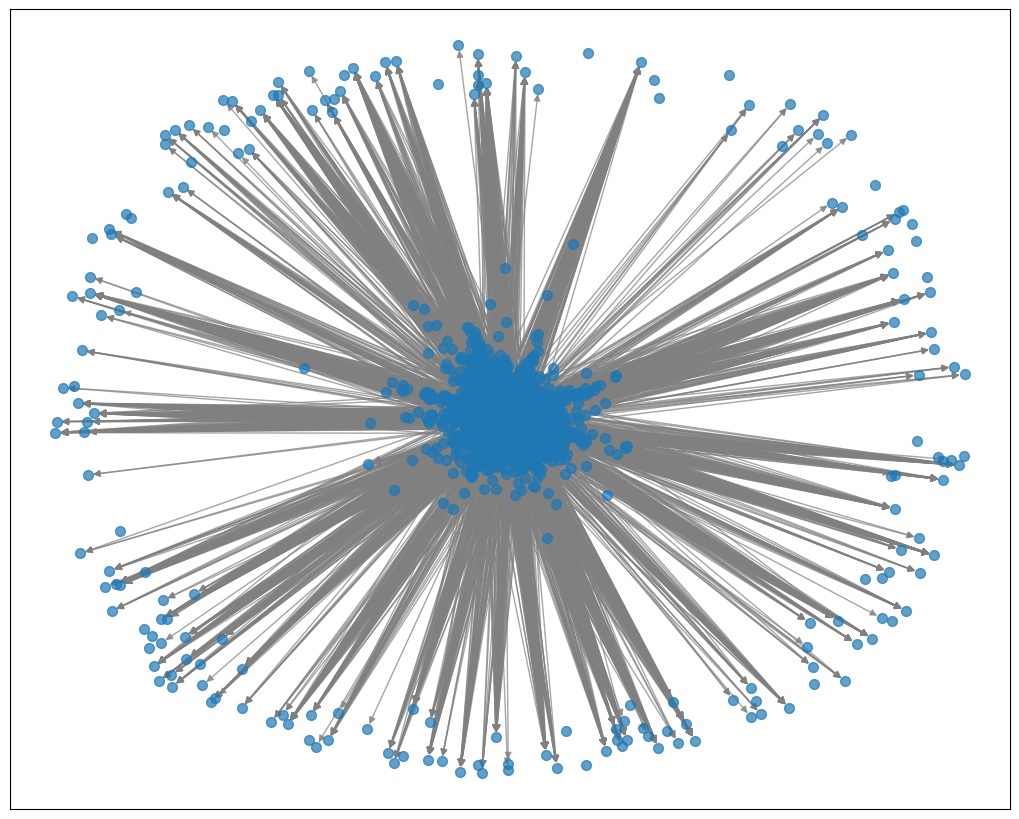

In [18]:
# Visualize the subgraph with basic layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_directed)
nx.draw(
    G_directed,
    pos,
    with_labels=False,
    node_size=50,
    edge_color='gray',
    alpha=0.7
)
plt.title("Directed Graph Visualization")
plt.show()

### Link Prediction

First we experiment with the directed version

In [12]:
# 1. Convert the directed votes dataset into a graph
G_directed = nx.from_pandas_edgelist(
    directed_votes,  # Replace with your DataFrame variable
    source="ID_CommunityIdentity_Source",
    target="ID_CommunityIdentity_Target",
    edge_attr="count_votes_to_postings_net",  # Optional: edge weights
    create_using=nx.DiGraph()  # Ensure a directed graph
)


In [13]:
# check if its directed
G_directed.is_directed()


True

In [ ]:
# create subgraph

# Sample a smaller subgraph
subgraph = G_directed.subgraph(list(G_directed.nodes)[:100])  # Adjust size


In [ ]:
#check number of nodes
subgraph.number_of_nodes()

100

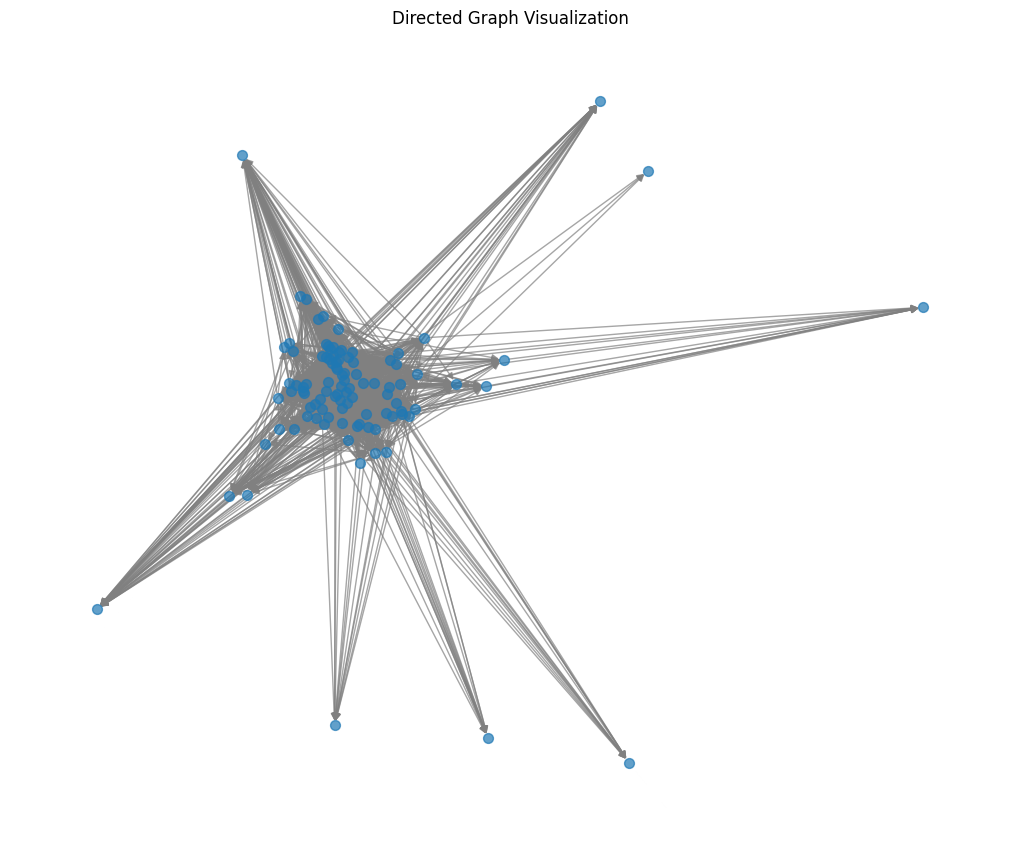

In [ ]:
# Visualize the subgraph with basic layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph)
nx.draw(
    subgraph,
    pos,
    with_labels=False,
    node_size=50,
    edge_color='gray',
    alpha=0.7
)
plt.title("Directed Graph Visualization")
plt.show()

### Preprocessing and train test split

In [14]:
# Extract edges
edges = list(G_directed.edges())

# Split edges into training, validation, and test sets
train_edges, test_edges = train_test_split(edges, test_size=0.3, random_state=42)  # 70% train, 30% test
train_edges, val_edges = train_test_split(train_edges, test_size=0.1, random_state=42)  # 10% validation


In [16]:
print(len(edges))

6105250


In [15]:
# Print the edge counts
print(f"Training edges (positive): {len(train_edges)}")
print(f"Validation edges (positive): {len(val_edges)}")
print(f"Test edges (positive): {len(test_edges)}")

Training edges (positive): 3846307
Validation edges (positive): 427368
Test edges (positive): 1831575


In [ ]:
all_possible_non_edges = set(nx.non_edges(G_directed))  # All node pairs not connected in the Graph
print(f"Total possible non-edges: {len(all_possible_non_edges)}")

In [ ]:
# Sample negative edges for validation and test sets
val_edges_false = random.sample(all_possible_non_edges, len(val_edges))
test_edges_false = random.sample(all_possible_non_edges - set(val_edges_false), len(test_edges))

# Generate negative edges for training
train_edges_false = random.sample(all_possible_non_edges - set(val_edges_false) - set(test_edges_false), len(train_edges))


/var/folders/h0/ypxj_t612537gn89tkfhrb_00000gn/T/ipykernel_37238/1037856570.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_edges_false = random.sample(all_possible_non_edges, len(val_edges))
/var/folders/h0/ypxj_t612537gn89tkfhrb_00000gn/T/ipykernel_37238/1037856570.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test_edges_false = random.sample(all_possible_non_edges - set(val_edges_false), len(test_edges))


In [ ]:
# Print counts
print(f"Training edges (negative): {len(train_edges_false)}")
print(f"Validation edges (negative): {len(val_edges_false)}")
print(f"Test edges (negative): {len(test_edges_false)}")

Training edges (negative): 1478
Validation edges (negative): 165
Test edges (negative): 705


In [ ]:
#Create Training Graph

G_train = nx.DiGraph()
G_train.add_edges_from(train_edges)

# Add all nodes from the subgraph to ensure no nodes are lost
G_train.add_nodes_from(subgraph.nodes())

# Verify the training graph
print(f"Number of nodes in training graph: {G_train.number_of_nodes()}")
print(f"Number of edges in training graph: {G_train.number_of_edges()}")

Number of nodes in training graph: 100
Number of edges in training graph: 1478


### Train Node2Vec

In [ ]:
# Train Node2Vec on the training graph

node2vec = Node2Vec(
    graph=G_train,
    dimensions=64,    # Embedding dimensions
    walk_length=30,   # Length of random walks
    num_walks=200,    # Number of random walks per node
    workers=4         # Parallel threads
)

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:00<00:00, 473.31it/s]


In [ ]:
# Fit the Node2Vec model
print("Training Node2Vec model...")
model = node2vec.fit()

# Access node embeddings
embeddings = {str(node): model.wv[str(node)] for node in G_train.nodes()}

Training Node2Vec model...


In [ ]:
# Function to generate edge features
def edge_to_feature(edge, embeddings):
    u, v = edge
    return embeddings[str(u)] + embeddings[str(v)]  # Element-wise addition

# Generate training data
X_train = [edge_to_feature(edge, embeddings) for edge in train_edges]  # Positive edges
y_train = [1] * len(train_edges)  # Positive labels

# Add negative edges to training data
X_train += [edge_to_feature(edge, embeddings) for edge in train_edges_false]
y_train += [0] * len(train_edges_false)  # Negative labels

In [ ]:
# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Validation
X_val = [edge_to_feature(edge, embeddings) for edge in val_edges]
X_val += [edge_to_feature(edge, embeddings) for edge in val_edges_false]
y_val = [1] * len(val_edges) + [0] * len(val_edges_false)

y_val_pred = clf.predict(X_val)
y_val_proba = clf.predict_proba(X_val)[:, 1]

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation AUC:", roc_auc_score(y_val, y_val_proba))

# Test
X_test = [edge_to_feature(edge, embeddings) for edge in test_edges]
X_test += [edge_to_feature(edge, embeddings) for edge in test_edges_false]
y_test = [1] * len(test_edges) + [0] * len(test_edges_false)

y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_proba))

Validation Accuracy: 0.7
Validation AUC: 0.7636730945821855
Test Accuracy: 0.701418439716312
Test AUC: 0.7625089281223277
